# MyoPS 2020 Challenge


In [1]:
import torch
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from glob import glob
from pathlib import Path

In [2]:
preds = glob("../pred/*/raw/*101*-0.pt")

In [3]:
preds

['../pred/multi_scar.4_full/raw/101-orig-0.pt',
 '../pred/multi_patho.35_full/raw/101-orig-0.pt',
 '../pred/multi_ce_full/raw/101-orig-0.pt',
 '../pred/multi_edema.4_full/raw/101-orig-0.pt']

In [4]:
preds_c = [torch.load(x).argmax(dim=0).numpy() for x in preds]

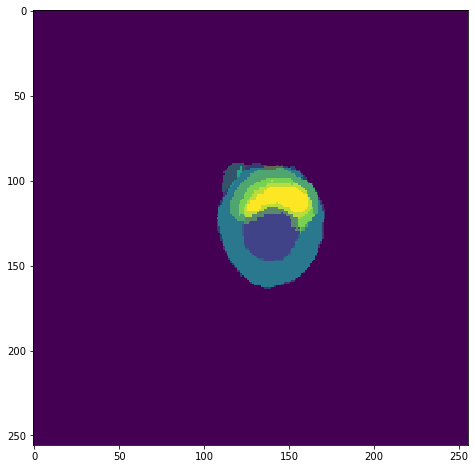

In [12]:
fig, axs = plt.subplots(figsize=(8,8))
axs.imshow(preds_c[0])
axs.imshow(preds_c[1], alpha=.5)

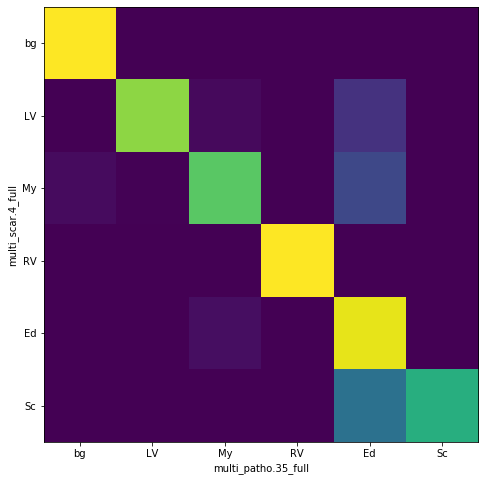

In [11]:
fig, axs = plt.subplots(figsize=(8,8))
_ = axs.imshow(confusion_matrix(preds_c[0].flatten(), preds_c[1].flatten(), normalize="true"))
_ = plt.xticks(range(6), labels=['bg','LV','My','RV','Ed','Sc'])
_ = plt.yticks(range(6), labels=['bg','LV','My','RV','Ed','Sc'])
_ = plt.xlabel(Path(preds[1]).parent.parent.name)
_ = plt.ylabel(Path(preds[0]).parent.parent.name)